# Final Project Submission

* Student name:  **John ODonnell**
* Student pace:  **self paced**
* Scheduled project review date/time: **5/4/21 4:00pm**
* Instructor name:  **Jeff Herman**
* Blog post URL:  **https://johnodonnell123.github.io/pages/page_blogpost_1.html**


## Approach
- For this project I opted to not use the provided dataset from IMDB/BOM/Rotten Tomatoes and instead scrape my own data. Roughly 80,000 titles were scraped from IMDB's website using Scrapy Crawlers. Fields scraped include the title, ratings, budget, director, genre, etc. The data is returned in a structured format (.csv) however it does need to be cleaned and analyzed. Pandas is used to import the .csv into a Dataframe where the fields are cleaned and prepared for analysis. Once cleaned I thought about what high-level views I might want to see assuming I was going to make a film. 
- I explored the relationship between budget and revenue, then how other production companies are translating their budgets into revenue for some competitor intelligence. The total revenue across different genres is assessed and there are some top genres that really stand out in terms of their gross figure distributions. Narrowing the field to just films in one of these top categories the most successfull writers and voice actors are identified for scouting purposes. Recommendations of the range of budgets, genre of film, and writers/actors are given. 

# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.graph_objects as go
pd.set_option('display.float_format', lambda x: '%.1f' % x)

# Import Data 
### (Scraped from IMDB.com)

In [2]:
df = pd.read_csv(r"C:\Users\johno\Python\Flatiron\Module_1_Final_Project\Flatiron_Module_1_Final_Project\Scraped Data\movies.csv")
df.sort_values('budget',inplace=True, ascending=False)
print(df.shape)
df.sample()

(83224, 13)


title                 date  star_rating  \
21283  Halloween: The Devil's Autumn   24 March 2020 (USA)          5.5   

       num_ratings  genres run_time    director writer stars  \
21283            6  Horror    52min  James Grim    NaN   NaN   

                                           plot_keywords              budget  \
21283  fan film,michael myers,mask,halloween,hallowee...  $0\r\n               

      cum_worldwide_gross production_company  
21283                 NaN                NaN

## View Missing Data
#### Most of the missing data is in our budget/revenue columns 

In [3]:
df.isna().mean()

title                 0.0
date                  0.0
star_rating           0.0
num_ratings           0.0
genres                0.0
run_time              0.0
director              0.0
writer                0.0
stars                 0.0
plot_keywords         0.1
budget                0.7
cum_worldwide_gross   0.8
production_company    0.1
dtype: float64

### Economics will be the metric for success instead of star rating
- Drop all rows missing data and see how many we have left

In [4]:
df = df.dropna()
print(df.shape)
df.isna().mean()

(9606, 13)


title                 0.0
date                  0.0
star_rating           0.0
num_ratings           0.0
genres                0.0
run_time              0.0
director              0.0
writer                0.0
stars                 0.0
plot_keywords         0.0
budget                0.0
cum_worldwide_gross   0.0
production_company    0.0
dtype: float64

### View a sample of the data

In [5]:
display(df.info())
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9606 entries, 63624 to 8272
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                9606 non-null   object 
 1   date                 9606 non-null   object 
 2   star_rating          9606 non-null   float64
 3   num_ratings          9606 non-null   int64  
 4   genres               9606 non-null   object 
 5   run_time             9606 non-null   object 
 6   director             9606 non-null   object 
 7   writer               9606 non-null   object 
 8   stars                9606 non-null   object 
 9   plot_keywords        9606 non-null   object 
 10  budget               9606 non-null   object 
 11  cum_worldwide_gross  9606 non-null   object 
 12  production_company   9606 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 1.0+ MB


None

title                             date  star_rating  \
63624  Finding Lenny       3 April 2009 (South Africa)          6.1   
74567  Cut-Out Girls   22 November 2019 (South Africa)          4.6   
17003     Platteland   25 November 2011 (South Africa)          6.3   

       num_ratings              genres  run_time        director  \
63624           52              Comedy  1h 34min  Neal Sundstrom   
74567           29            Thriller  1h 25min  Nicola Hanekom   
17003          152  Action,Drama,Music        2h       Sean Else   

                writer                                              stars  \
63624  Russel Savadier         Barry Hilton,Russel Savadier,Yule Masiteng   
74567   Nicola Hanekom  Joel Rosenblatt,Ashleigh van der Hoven,Cody Mo...   
17003        Sean Else             Lianie May,Bok van Blerk,Steve Hofmeyr   

                                        plot_keywords  \
63624  soccer,zulu,tribal,south africa,midlife crisis   
74567                                            live   
17003                        afrikaans,one word title   

                             budget  cum_worldwide_gross  \
63624  ZAR9,000,000\r\n                  $55,662           
74567    ZAR800,000\r\n                   $8,682           
17003  ZAR8,000,000\r\n               $1,069,699           

            production_company  
63624                Moviworld  
74567             Haas en Kaas  
17003   Philo Films (Pty) Ltd.

### Notes:
- `date` needs to be cleaned and converted to datetime
- `run_time` needs to be converted to minutes as an integer
- `genres` and `stars` need to be cast to lists so they can be searched
- `budget` and `cum_worldwide_gross` need to be cast to integers
    - `Budget` contains values in other currencies, these titles can be removed 

# High Level Cleaning

### Dates

In [6]:
# Remove the country code from the string, then convert to pandas datetime 
date = df['date'].str.split("(",n=1,expand=True)
df['date'] = pd.to_datetime(date[0],infer_datetime_format=True)
df['country'] = date[1].str.replace(")","")
df[['title','date','country']].head(3)

<ipython-input-6-fab5987bdfe9>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['country'] = date[1].str.replace(")","")


title       date       country
63624  Finding Lenny  2009-04-03  South Africa
74567  Cut-Out Girls  2019-11-22  South Africa
17003     Platteland  2011-11-25  South Africa

### Run_time
- Currently in string format at num hours and num minutes, need to cast as integer representing minute count
- Example: "1h 30min" needs to be 90

In [7]:
df.head(1)

title       date  star_rating  num_ratings  genres  run_time  \
63624  Finding Lenny  2009-04-03          6.1           52  Comedy  1h 34min   

             director           writer  \
63624  Neal Sundstrom  Russel Savadier   

                                            stars  \
63624  Barry Hilton,Russel Savadier,Yule Masiteng   

                                        plot_keywords  \
63624  soccer,zulu,tribal,south africa,midlife crisis   

                             budget cum_worldwide_gross production_company  \
63624  ZAR9,000,000\r\n                 $55,662                  Moviworld   

            country  
63624  South Africa

In [8]:
def to_minutes(string):
    ''' Returns minutes as an integer given a string containing hours and minutes '''
    hours_in_minutes = 0
    minutes = 0
    
    if  "h" in string:
        hours_in_minutes = int(string.split()[0].replace("h",'')) * 60
        
    if "min" in string:
        minutes = int(string.split()[1].replace('min',''))    
        
    return hours_in_minutes + minutes
    
df['run_time_min'] = df['run_time'].map(to_minutes)
df = df.drop(columns=['run_time'])
df.head(1)

title       date  star_rating  num_ratings  genres  \
63624  Finding Lenny  2009-04-03          6.1           52  Comedy   

             director           writer  \
63624  Neal Sundstrom  Russel Savadier   

                                            stars  \
63624  Barry Hilton,Russel Savadier,Yule Masiteng   

                                        plot_keywords  \
63624  soccer,zulu,tribal,south africa,midlife crisis   

                             budget cum_worldwide_gross production_company  \
63624  ZAR9,000,000\r\n                 $55,662                  Moviworld   

            country  run_time_min  
63624  South Africa            94

### Budget
##### Clean Budget: remove titles with budgets not in USD, remove non-numeric characters cast to integer

In [9]:
def special_match(strg, search=re.compile(r'[^0-9]').search):
    ''' Returns False if a string contains any non-nuemric tokens, used as a boolean mask in filtering'''
    return not bool(search(strg))

df['budget'] = df['budget'].str.replace(",","").str.replace("$","").str.rstrip()
df = df[df['budget'].map(special_match)]
df['budget_MM'] = df['budget'].astype(int)/1000000
df = df.drop(columns=['budget'])
print(df.shape)
df.sample()

(8250, 14)


<ipython-input-9-fc255de9cd88>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['budget'] = df['budget'].str.replace(",","").str.replace("$","").str.rstrip()


title       date  star_rating  num_ratings         genres  \
32558  Days of Heaven  1978-10-06          7.8        53796  Drama,Romance   

              director           writer  \
32558  Terrence Malick  Terrence Malick   

                                       stars  \
32558  Richard Gere,Brooke Adams,Sam Shepard   

                                     plot_keywords  cum_worldwide_gross  \
32558  farm,train,wealth,farm worker,seasonal work   $3,475,702           

        production_company country  run_time_min  budget_MM  
32558   Paramount Pictures     USA            94        3.0

### Revenue
##### Clean other numerical types and cast to integers
##### Calculate ROI

In [10]:
df['cum_worldwide_gross_MM'] = df['cum_worldwide_gross'].str.replace(",","").str.replace("$","").astype(float) / 1000000
df = df.drop(columns=['cum_worldwide_gross'])
df['ROI'] = df['cum_worldwide_gross_MM'] / df['budget_MM']

<ipython-input-10-40c9703583bc>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['cum_worldwide_gross_MM'] = df['cum_worldwide_gross'].str.replace(",","").str.replace("$","").astype(float) / 1000000


### Cast `genres` and `stars` to lists
##### Get the first star from the list of stars as the `main_star` (the list is ordered, and is not alphabetical)

In [11]:
df['genres'] = df['genres'].str.split(",")
df['stars'] = df['stars'].str.split(",")
df['main_star'] = df['stars'].apply(lambda x: x[0])

In [12]:
print(df.shape)
df.sample()

(8250, 16)


title       date  star_rating  num_ratings  \
83095  Alvin and the Chipmunks  2007-12-14          5.2        78118   

                                                  genres  director     writer  \
83095  [Animation, Adventure, Comedy, Family, Fantasy...  Tim Hill  Jon Vitti   

                                                  stars  \
83095  [Jason Lee, Ross Bagdasarian Jr., Janice Karman]   

                                           plot_keywords  production_company  \
83095  concert,talking animal,new york city,chipmunk,...   Fox 2000 Pictures   

      country  run_time_min  budget_MM  cum_worldwide_gross_MM  ROI  main_star  
83095     USA            92       60.0                   365.4  6.1  Jason Lee

# Question #1: Does a larger budget translate into more revenue?

### Create Plot: "Budget vs. Revenue"

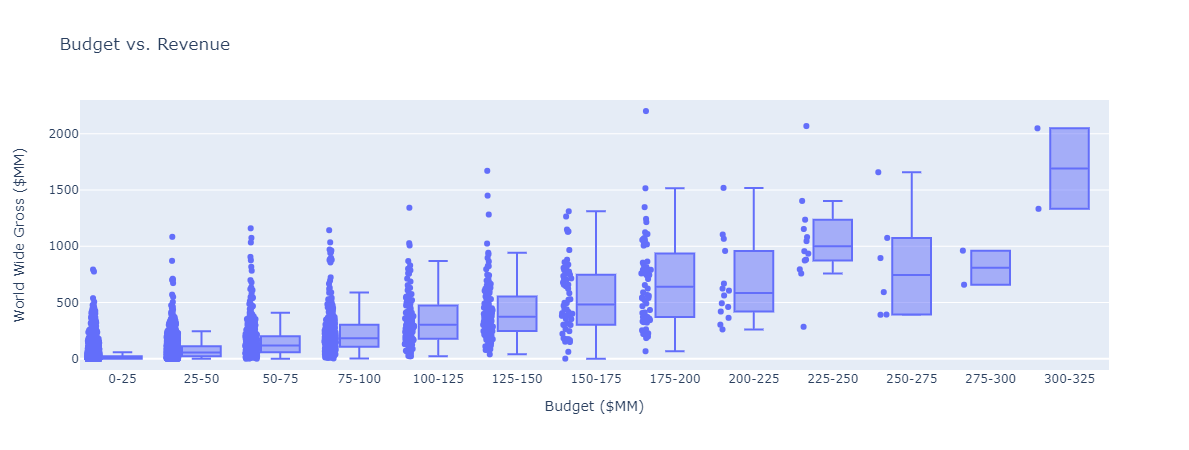

In [13]:
df.sort_values(by='budget_MM', inplace=True)

Bins = [b for b in range(0,350,25)]
Labels = [f"{i}-{i + Bins[2]-Bins[1]}" for i in Bins]

budget_MM_bined = pd.cut(df['budget_MM'], bins= Bins, labels = Labels[:-1])

fig = px.box(df, 
             x = budget_MM_bined, 
             y = 'cum_worldwide_gross_MM', 
             points = 'all',
             title = "Budget vs. Revenue",
             labels = {'x':'Budget ($MM)',
                     "cum_worldwide_gross_MM": "World Wide Gross ($MM)"
                     },
             width = 900,
             height = 450,
             hover_data = ['budget_MM','title'])

fig.update_layout(yaxis_range=[-100,2300])

fig.show()

### Interpretation:
- There does appear to be a positive correlation between budgets and world-wide gross revenue. There is a wide range of outcomes across all budgets, but the quartiles of our dataset shows a consistent shift higher as budgets increase
    - Sample size *is* smaller in on the higher end, something to keep in mind
- Depending on the goal of the company (Microsoft), if there is an NPV target to be achieved and not just one of ROI having a appropriate budget appears to increase the changes of meeting that goal

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Question #2: Which of the largest 10 studios does the best job of translating their budget to income?
### (Competitor Intelligence)

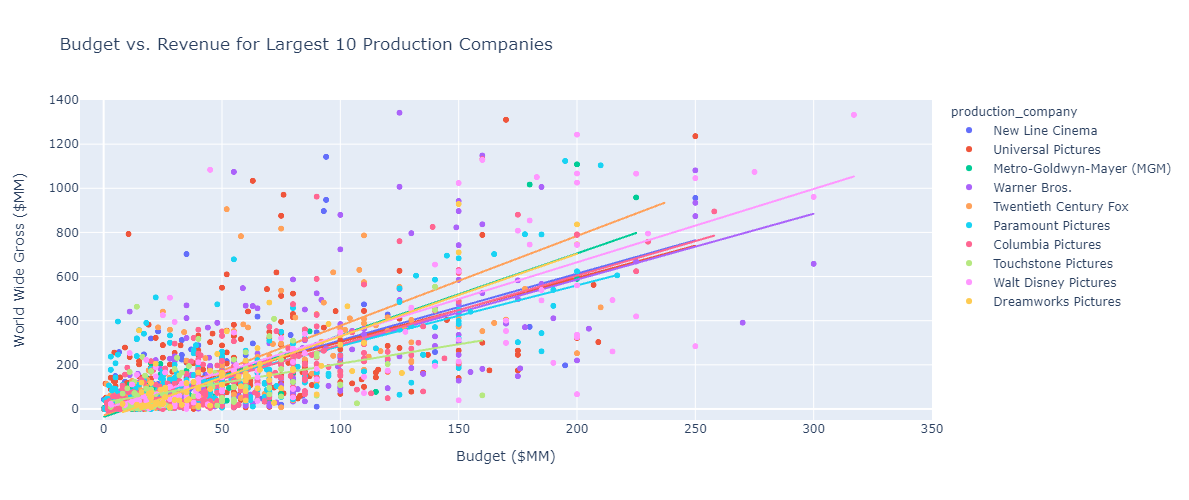

In [14]:
top_10_studios = df[df['production_company'].isin(df['production_company'].value_counts().index.tolist()[:10])]

fig = px.scatter(top_10_studios, 
                 x="budget_MM", 
                 y="cum_worldwide_gross_MM", 
                 hover_data=['title','date'], 
                 trendline='ols',
                 color = 'production_company', 
                 title = "Budget vs. Revenue for Largest 10 Production Companies",
                 labels = {"budget_MM": "Budget ($MM)",
                           "cum_worldwide_gross_MM": "World Wide Gross ($MM)"
                           },
                 height = 500, 
                 width = 800, )

fig.update_layout(yaxis_range=[-50,1400],
                  xaxis_range=[-10,350])

fig.show()

### Interpretation:
- There are differences between these production companies in terms of their relationships with budget and revenue
- Twentieth Century Fox appear to outperform Warner Bros consistently
    - A deeper dive into some of the better performing studios (Fox, MGM, Dreamworks) is warranted to discover what they are doing differently from the other less successful studios

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Question #3: Which genres have the best distributions of World-Wide Revenue?

- Calculate ROI
- Get list of unique genres sorted by median ROI

In [15]:
# Define function to sort genres by given metric
def top_n_genres(col_name, n, quantile):
    ''' Returns a list of the top n genres of the provided column using the median'''
    
    # Create dictionary where genres are keys and the median ROI for that genre is the value
    unique_genre_list = sorted(list({x for l in df['genres'] for x in l}))
    genre_dict = {}
    for genre in unique_genre_list:
        median = df[df['genres'].apply(lambda x: genre in x)][col_name].quantile(quantile)
        genre_dict[genre] = median 
    genre_dict = {k:v for k,v in sorted(genre_dict.items(), key = lambda items: items[1],reverse=True)}
    top_n_genre_list = list(genre_dict.keys())[:n]
    return top_n_genre_list

top_n_genres('cum_worldwide_gross_MM', 5, 0.75)

['Animation', 'Adventure', 'Family', 'Fantasy', 'Sci-Fi']

## Create Plot: Revenue by Genre

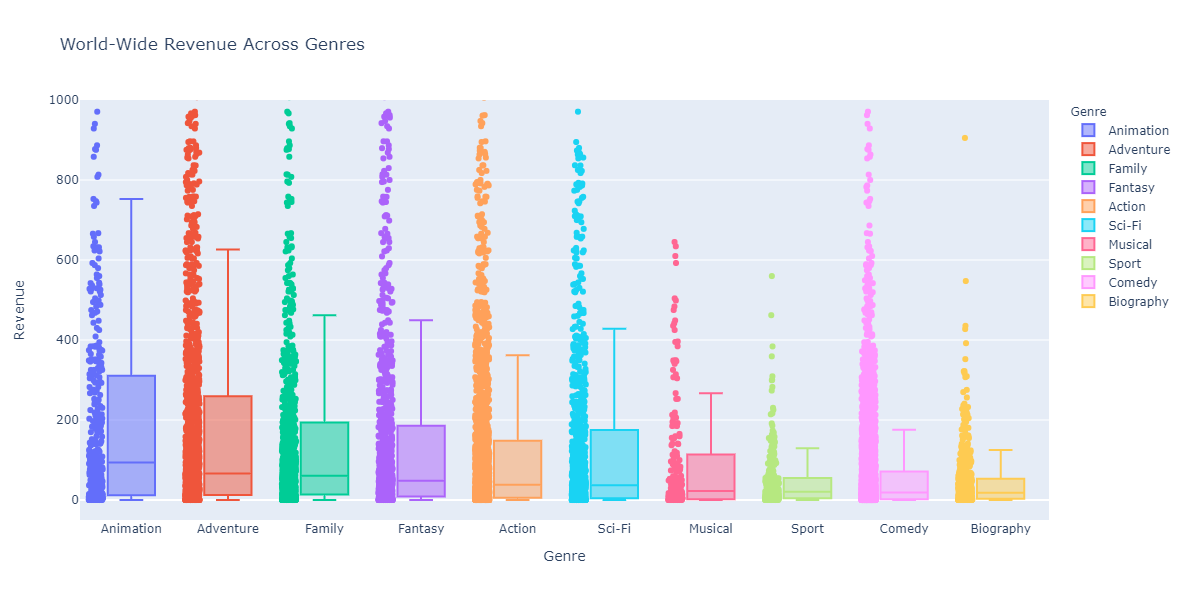

In [16]:
fig = go.Figure()

for genre in top_n_genres('cum_worldwide_gross_MM', 10, 0.5):
    fig.add_trace(go.Box(y=df[df['genres'].apply(lambda x: genre in x)]['cum_worldwide_gross_MM'], name=genre))

fig.update_layout(
    title="World-Wide Revenue Across Genres",
    xaxis_title="Genre",
    yaxis_title="Revenue",
    legend_title="Genre",
    autosize=False,
    width=1200,
    height=600,
    yaxis_range=[-50,1000]
)

fig.update_traces(boxpoints='all', jitter=.3)

fig.show()

### Interpretation:
- Animation, Family, and Adventure appear to have the most favorable distributions of Revenue (High IQR)
- According to this plot, making an animation film with family and adventure themes will likely lead to higher revenues
    - It would be much more difficult to achieve high revenues with genres such as sport, biography, or comedy

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Question #4: Which Animation Writer's films have accumulated the most revenue? 
### Which of their titles has the highest gross revenue?

##### Create DataFrame Grouped by Director

In [17]:
df_writers = pd.DataFrame()

df_animation = df[df['genres'].apply(lambda x: 'Animation' in x)]

df_writers['num_movies_written'] = df_animation.groupby('writer')['writer'].count()

df_writers['budget_MM'] = df_animation.groupby('writer')['budget_MM'].sum()
df_writers['cum_worldwide_gross_MM'] = df_animation.groupby('writer')['cum_worldwide_gross_MM'].sum()

df_writers['titles'] = df_animation.groupby('writer')['title'].apply(list)
df.sort_values('cum_worldwide_gross_MM',ascending=False,inplace=True)
df_writers['highest_grossing_title'] = df_animation.groupby('writer')['title'].first()
df_writers['Revenue_per_film'] = df_writers['cum_worldwide_gross_MM'] / df_writers['num_movies_written']

df_writers.sort_values('cum_worldwide_gross_MM',inplace=True,ascending=False)
df_writers.head(10)

num_movies_written  budget_MM  cum_worldwide_gross_MM  \
writer                                                                  
John Lasseter                    8     1010.0                  4656.5   
Cinco Paul                       6      448.0                  3906.7   
Jonathan Aibel                   7      789.0                  2878.2   
Jennifer Lee                     2      300.0                  2731.9   
Brad Bird                        3      442.0                  2498.4   
Andrew Stanton                   3      474.0                  2490.2   
Pete Docter                      3      465.0                  2172.9   
Michael Berg                     2      185.0                  1763.9   
Jeff Nathanson                   1      260.0                  1657.9   
Brian Lynch                      2      154.0                  1589.5   

                                                           titles  \
writer                                                              
John Lasseter   [Toy Story , Planes , Toy Story 2 , A Bug's Li...   
Cinco Paul      [Hop , Despicable Me , The Secret Life of Pets...   
Jonathan Aibel  [The SpongeBob Movie: Sponge Out of Water , Al...   
Jennifer Lee                                [Frozen II , Frozen ]   
Brad Bird        [The Incredibles , Ratatouille , Incredibles 2 ]   
Andrew Stanton            [Finding Nemo , WALL·E , Finding Dory ]   
Pete Docter                   [Monsters, Inc. , Inside Out , Up ]   
Michael Berg    [Ice Age: Dawn of the Dinosaurs , Ice Age: Con...   
Jeff Nathanson                                   [The Lion King ]   
Brian Lynch                [Minions , The Secret Life of Pets 2 ]   

                                   highest_grossing_title  Revenue_per_film  
writer                                                                       
John Lasseter                                  Toy Story              582.1  
Cinco Paul                                           Hop              651.1  
Jonathan Aibel  The SpongeBob Movie: Sponge Out of Water              411.2  
Jennifer Lee                                   Frozen II             1365.9  
Brad Bird                                The Incredibles              832.8  
Andrew Stanton                              Finding Nemo              830.1  
Pete Docter                               Monsters, Inc.              724.3  
Michael Berg              Ice Age: Dawn of the Dinosaurs              882.0  
Jeff Nathanson                             The Lion King             1657.9  
Brian Lynch                                      Minions              794.7

### Create Plot: Top 10 Animation Writers

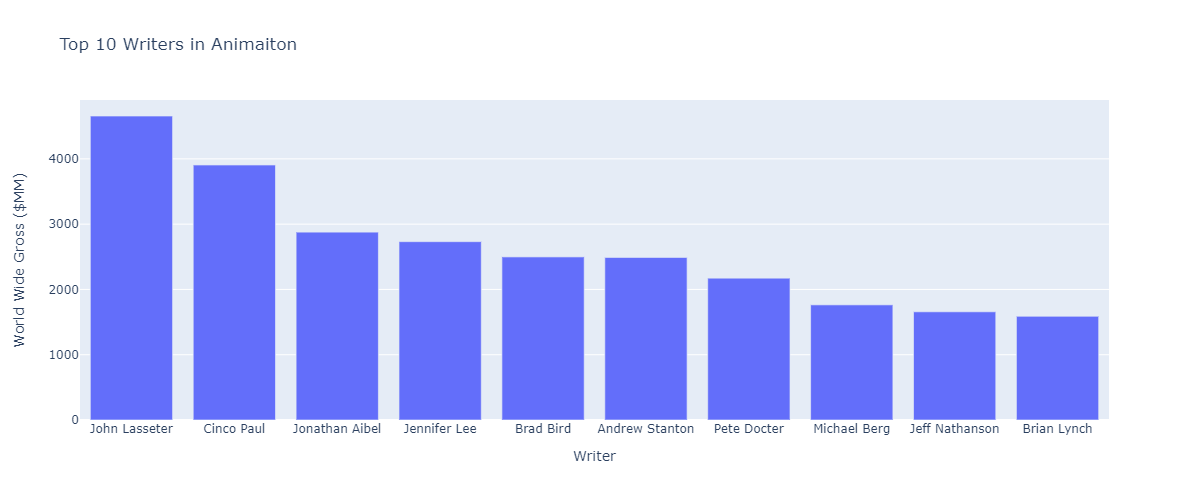

In [18]:
top_10_writers = df_writers.head(10) 

fig = px.bar(top_10_writers, 
             x = top_10_writers.index, 
             y='cum_worldwide_gross_MM',
             title = "Top 10 Writers in Animaiton",
             labels = {"cum_worldwide_gross_MM": "World Wide Gross ($MM)",
                      'writer':"Writer"},
             width = 900, height = 500)
fig.show()

### Interpretation:
- John Lasseter and Cinco Paul appear to be the dominant names in animation writing
- Recruiting the top writers in the the top genre (animation) should lead to higher revenue

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Question #5: Which Animation (Voice) actors bring in the most revenue? 

In [19]:
df_animation = df[df['genres'].apply(lambda x: 'Animation' in x)]

In [20]:
df_actors = pd.DataFrame()

df_actors['num_movies'] = df_animation.groupby('main_star')['main_star'].count()

df_actors['budget_MM'] = df_animation.groupby('main_star')['budget_MM'].sum()
df_actors['cum_worldwide_gross_MM'] = df_animation.groupby('main_star')['cum_worldwide_gross_MM'].sum()

df.sort_values('cum_worldwide_gross_MM',ascending=False,inplace=True)
df_actors['highest_grossing_titles'] = df_animation.groupby('main_star')['title'].apply(list)
df_actors['best_title'] = df_animation.groupby('main_star')['title'].first()

df_actors.sort_values('cum_worldwide_gross_MM',inplace=True,ascending=False)
df_actors.head(10)

num_movies  budget_MM  cum_worldwide_gross_MM  \
main_star                                                        
Tom Hanks                 5      685.0                  3346.4   
Mike Myers                4      535.0                  2982.6   
Ray Romano                4      370.0                  2839.8   
Kristen Bell              2      300.0                  2731.9   
Steve Carell              3      225.0                  2548.7   
Jack Black                4      483.0                  1976.9   
Craig T. Nelson           2      292.0                  1874.7   
Donald Glover             1      260.0                  1657.9   
Jay Baruchel              3      439.0                  1642.2   
Owen Wilson               4      545.0                  1489.5   

                                           highest_grossing_titles  \
main_star                                                            
Tom Hanks        [Toy Story 4 , Toy Story 3 , Toy Story 2 , Toy...   
Mike Myers       [Shrek 2 , Shrek the Third , Shrek Forever Aft...   
Ray Romano       [Ice Age: Dawn of the Dinosaurs , Ice Age: Con...   
Kristen Bell                                 [Frozen II , Frozen ]   
Steve Carell     [Despicable Me 3 , Despicable Me 2 , Despicabl...   
Jack Black       [Kung Fu Panda 2 , Kung Fu Panda , Kung Fu Pan...   
Craig T. Nelson                 [Incredibles 2 , The Incredibles ]   
Donald Glover                                     [The Lion King ]   
Jay Baruchel     [How to Train Your Dragon 2 , How to Train You...   
Owen Wilson                  [Cars 2 , Cars , Cars 3 , Marmaduke ]   

                                      best_title  
main_star                                         
Tom Hanks                           Toy Story 4   
Mike Myers                              Shrek 2   
Ray Romano       Ice Age: Dawn of the Dinosaurs   
Kristen Bell                          Frozen II   
Steve Carell                    Despicable Me 3   
Jack Black                      Kung Fu Panda 2   
Craig T. Nelson                   Incredibles 2   
Donald Glover                     The Lion King   
Jay Baruchel         How to Train Your Dragon 2   
Owen Wilson                              Cars 2

### Create Plot: Top 15 Voice Actors in Animation

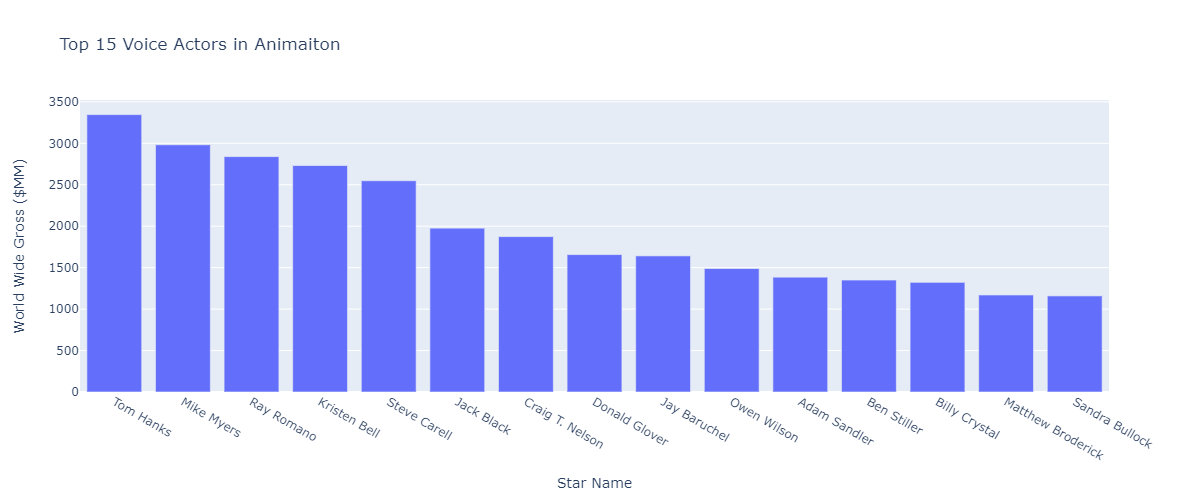

In [21]:
top_15_actors = df_actors.head(15)

fig = px.bar(top_15_actors, 
             x = top_15_actors.index, 
             y='cum_worldwide_gross_MM',
             title = "Top 15 Voice Actors in Animaiton",
             labels = {"cum_worldwide_gross_MM": "World Wide Gross ($MM)",
                      'main_star':'Star Name'},
             width = 900, height = 500)
fig.show()

### Interpretation:
- Tom Hanks, Mike Mysers, Ray Romano, Kristen Bell, and Steve Carrell are to be the dominant names in animation voice acting
- Recruiting the top voice actors in the the top genre (animation) should lead to higher revenue

##### 
##### <center>-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</center>
##### 

# Future Work

### Ideas:
- Continue to analyze the more successfull studios identified in question #2 to search for systematic differences that might explain the differences seen in relationships in budget and revenue
- Build a distribution for Animation/Adventure/Family movies with top writers and voice actors and compare them to some other top categories
- Build machine learning model (linear-regression, random forest, neural net) to predict gross revenue, assess accuracy and feature importances/relationships